In [1]:
# Import modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import random
import pickle

# ignore deprecation warnings in sklearn

import warnings
warnings.filterwarnings("ignore")

# Specify data directory

data_dir = os.path.join(os.path.dirname(os.getcwd()),'Data')

# Set model directory

model_dir = os.path.join(os.path.dirname(os.getcwd()), 'Model')

# Set data paths

train_path = os.path.join(data_dir, 'train.csv')

train_processed_path = os.path.join(data_dir, 'interim', 'train_preprocessed.txt')

dense_feat_path = os.path.join(data_dir, 'interim', 'dense_feat.txt')

train = pd.read_csv(train_path)
train_processed = pd.read_json(train_processed_path)
dense_feat = pd.read_json(dense_feat_path)

In [2]:
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import tensorflow.keras.backend as K
import re
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


In [3]:
from sklearn.utils.class_weight import compute_sample_weight

class_weights = compute_sample_weight('balanced', 
                                      np.unique(train_processed.sentiment),
                                      train_processed.sentiment)

In [4]:
# Set hyper-parameters

max_feature = 2000
#max_len = 90
embed_dim = 32
lstm_out = 100
batch_size = 16
num_epochs = 5

(3959, 50) (3959, 3)
(1320, 50) (1320, 3)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 32)            64000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 117,503
Trainable params: 117,503
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



     0    1    2
0  0.0  1.0  0.0
1  0.0  0.0  1.0
2  0.0  0.0  1.0
3  0.0  0.0  1.0
4  0.0  0.0  1.0


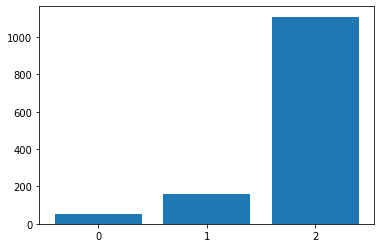

F1-SCORE for max length of 50 is 0.427290
(3959, 100) (3959, 3)
(1320, 100) (1320, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           64000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 117,503
Trainable params: 117,503
Non-trainable params: 0
_________________________________________________________________
None



     0    1    2
0  0.0  0.0  1.0
1  0.0  0.0  1.0
2  0.0  0.0  1.0
3  0.0  0.0  1.0
4  0.0  0.0  1.0


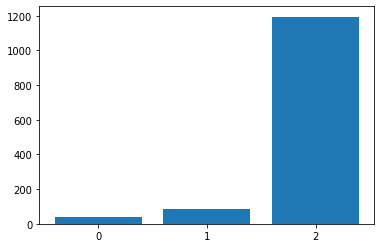

F1-SCORE for max length of 100 is 0.382646
(3959, 150) (3959, 3)
(1320, 150) (1320, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 32)           64000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 117,503
Trainable params: 117,503
Non-trainable params: 0
_________________________________________________________________
None



     0    1    2
0  0.0  1.0  0.0
1  0.0  0.0  1.0
2  0.0  0.0  1.0
3  0.0  0.0  1.0
4  0.0  0.0  1.0


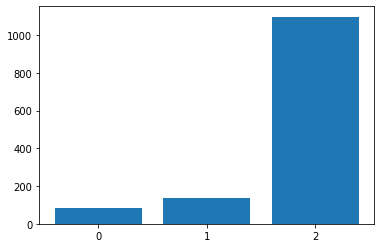

F1-SCORE for max length of 150 is 0.423769
(3959, 200) (3959, 3)
(1320, 200) (1320, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 32)           64000     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 303       
Total params: 117,503
Trainable params: 117,503
Non-trainable params: 0
_________________________________________________________________
None



     0    1    2
0  0.0  1.0  0.0
1  0.0  0.0  1.0
2  0.0  0.0  1.0
3  0.0  0.0  1.0
4  0.0  1.0  0.0


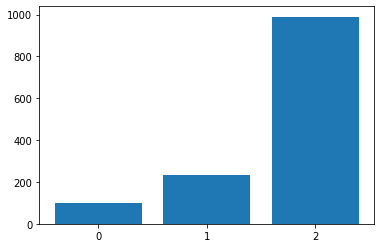

F1-SCORE for max length of 200 is 0.450490
(3959, 250) (3959, 3)
(1320, 250) (1320, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 250, 32)           64000     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 303       
Total params: 117,503
Trainable params: 117,503
Non-trainable params: 0
_________________________________________________________________
None



     0    1    2
0  0.0  0.0  1.0
1  0.0  0.0  1.0
2  0.0  0.0  1.0
3  0.0  0.0  1.0
4  0.0  0.0  1.0


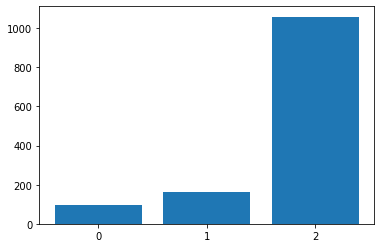

F1-SCORE for max length of 250 is 0.432905
(3959, 300) (3959, 3)
(1320, 300) (1320, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 32)           64000     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 303       
Total params: 117,503
Trainable params: 117,503
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
max_lens = np.arange(50,400,50)
f1_grid = {}
history_grid = {}

for max_len in max_lens:
    # Tokenization and build model input

    tokenizer = Tokenizer(num_words=max_feature, split=' ')
    tokenizer.fit_on_texts(train_processed['text'].values)

    X = tokenizer.texts_to_sequences(train_processed['text'].values)
    X = pad_sequences(X, maxlen = max_len)

    y = to_categorical(train_processed['sentiment'].values)

    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, random_state = 42)
    print(Xtrain.shape,ytrain.shape)
    print(Xtest.shape,ytest.shape)

    # Build Neural Network architecture

    model = Sequential()
    model.add(Embedding(max_feature, 
                        embed_dim, 
                        input_length = X.shape[1], 
                        dropout=0.2))
    model.add(LSTM(lstm_out, 
                   dropout_U=0.2,
                   dropout_W=0.2))
    model.add(Dense(3,
                    activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    print(model.summary())

    # Train and validate model

    Xvalid, yvalid = Xtrain[:batch_size], ytrain[:batch_size]
    Xtrain1, ytrain1 = Xtrain[batch_size:], ytrain[batch_size:]
    model.fit(Xtrain1, ytrain1, 
              validation_data=(Xvalid, yvalid), 
              batch_size=batch_size, 
              epochs=num_epochs,
              class_weight = class_weights,
              verbose = 0,
              callbacks = [TQDMNotebookCallback()])


    # Evaluate score 

    scores = model.evaluate(Xtest, ytest, verbose=10)
    ypred = model.predict(Xtest)
    ypred_df = pd.DataFrame(ypred)
    ypred_max = ypred_df.apply(max, axis = 1)
    for index, row in ypred_df.iterrows():
        for label, item in row.items():
            if item == ypred_max[index]:
                row[label] = 1
            else:
                row[label] = 0
    print(ypred_df.head())

    plt.bar(x = [0,1,2],
       height = [np.sum(ypred_df[0]), np.sum(ypred_df[1]), np.sum(ypred_df[2])])
    plt.xticks([0,1,2])
    plt.show()

    # Saving score
    f1_s = f1_score(ytest, ypred_df, average = 'macro')
    f1_grid[max_len] = f1_s
    history_grid[max_len] = model.history
    print("F1-SCORE for max length of %d is %f"  % (max_len, f1_s))

In [ ]:
pd.DataFrame.from_dict(f1_grid, orient = 'index').plot(legend = None)
plt.title('F1_score across max lengths')
plt.xlabel('max length')
plt.ylabel('F1 Score')
plt.show()

In [ ]:
filename = 'f1_vs_maxlen_5epoch.sav'
pd.DataFrame.from_dict(f1_grid, orient = 'index').to_pickle(os.path.join(model_dir, 'rnn', filename))